## Importing and Installing Modules


In [1]:
# Install jdk8
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
# Set jdk environment path which enables you to run Pyspark in your Colab environment.
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
!update-alternatives --set java /usr/lib/jvm/java-8-openjdk-amd64/jre/bin/java

In [2]:
!pip install pyspark==2.3.0

In [3]:
#import module
from pyspark.ml.recommendation import ALS
from pyspark.sql import SparkSession
from pyspark import SparkContext
from pyspark.sql.functions import col
from pyspark.sql import SQLContext
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.types import StructType, StructField, IntegerType
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import json
import gzip
from copy import deepcopy
import time
from scipy.sparse.linalg import svds
from sklearn.metrics import mean_absolute_error

## Datasets
Amazon Grocery Data

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
url='/content/drive/MyDrive/dataset/amazon_grocery_subset.csv'

In [6]:
#create session
appName = "Recommendation system in Spark with ALS"
spark = SparkSession \
    .builder \
    .appName(appName) \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

In [7]:
df1 = pd.read_csv(url)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [8]:
df1.head(3)

,Unnamed: 0,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,image,style
0,2029665,3.0,True,"03 25, 2014",A17GONA7VU3OVP,B007SM6NWC,Dennis P Harper,"I like the taste, texture, and idea of this fl...",Good but pricey,1395705600,NaN,NaN,NaN
1,1138829,5.0,True,"07 23, 2015",A1TS69PHM6K2CM,B001SAY1FG,Esweeney,Great,Five Stars,1437609600,NaN,NaN,NaN
2,2283487,5.0,True,"05 11, 2013",A1ATSQF1AB6DTM,B00BK80U60,Pdachsie,Barry's is my favorite tea. I drink decaf in ...,Barrys Tea ... the best,1368230400,NaN,NaN,NaN


In [9]:
df_metadata= []
with gzip.open(r'/content/meta_Grocery_and_Gourmet_Food.json.gz') as f:
    for l in f:
        df_metadata.append(json.loads(l.strip()))
print(len(df_metadata))
print(df_metadata[0])

287051
{'category': ['Grocery & Gourmet Food', 'Dairy, Cheese & Eggs', 'Cheese', 'Gouda'], 'tech1': '', 'description': ['BEEMSTER GOUDA CHEESE AGED 18/24 MONTHS', 'Statements regarding dietary supplements have not been evaluated by the FDA and are not intended to diagnose, treat, cure, or prevent any disease or health condition.'], 'fit': '', 'title': 'Beemster Gouda - Aged 18/24 Months - App. 1.5 Lbs', 'also_buy': [], 'tech2': '', 'brand': 'Ariola Imports', 'feature': [], 'rank': '165,181 in Grocery & Gourmet Food (', 'also_view': ['B0000D9MYM', 'B0000D9MYL', 'B00ADHIGBA', 'B00H9OX598', 'B001LM42GY', 'B001LM5TDY'], 'main_cat': 'Grocery', 'similar_item': '', 'date': '', 'price': '$41.91', 'asin': '0681727810', 'imageURL': [], 'imageURLHighRes': []}


In [10]:
df_metadata = pd.DataFrame.from_dict(df_metadata)
print(len(df_metadata))

287051


In [11]:
prod = deepcopy(df_metadata)
prod = prod[['asin', 'title', 'category']]

In [12]:
prod_title=prod[['asin', 'title']]

In [13]:
prod

,asin,title,category
0,0681727810,Beemster Gouda - Aged 18/24 Months - App. 1.5 Lbs,"[Grocery & Gourmet Food, Dairy, Cheese & Eggs,..."
1,0853347867,Trim Healthy Mama Xylitol,"[Grocery & Gourmet Food, Cooking & Baking, Sug..."
2,1888861118,Letter C - Swarovski Crystal Monogram Wedding ...,"[Grocery & Gourmet Food, Cooking & Baking, Fro..."
3,1888861517,Letter H - Swarovski Crystal Monogram Wedding ...,"[Grocery & Gourmet Food, Cooking & Baking, Fro..."
4,1888861614,Letter S - Swarovski Crystal Monogram Wedding ...,"[Grocery & Gourmet Food, Cooking & Baking, Fro..."
...,...,...,...
287046,B01HJFBN9A,"Caffarel Fruit Jellies, Organic Assorted, 200 ...","[Grocery & Gourmet Food, Jams, Jellies & Sweet..."
287047,B01HJFC704,"HAMPTON CREEK Spo Just Truffle Mayo, 12 Ounce","[Grocery & Gourmet Food, Condiments & Salad Dr..."
287048,B01HJF6FRA,"HAMPTON CREEK Just Ranch Dressing, 12 Fluid Ounce","[Grocery & Gourmet Food, Condiments & Salad Dr..."
287049,B01HJHSVG6,Gourmet Pure Vanilla Bean Pastes - Organically...,"[Grocery & Gourmet Food, Herbs, Spices & Seaso..."


Dropping duplicate rows

In [19]:
dataset=deepcopy(df1)
dataset.drop(['image','style','vote','reviewText','reviewerName','verified','summary'],axis=1, inplace = True)
dataset.fillna(value = 0, inplace = True)
dataset.drop_duplicates

<bound method DataFrame.drop_duplicates of          Unnamed: 0  overall  ...        asin unixReviewTime
0           2029665      3.0  ...  B007SM6NWC     1395705600
1           1138829      5.0  ...  B001SAY1FG     1437609600
2           2283487      5.0  ...  B00BK80U60     1368230400
3           1525007      5.0  ...  B004H1YIBU     1416355200
4           3610756      2.0  ...  B0192RC15I     1480118400
...             ...      ...  ...         ...            ...
1014827     3780068      5.0  ...  B01FUY1W4I     1531267200
1014828     4421977      5.0  ...  B00BHFEU8K     1515801600
1014829      971825      4.0  ...  B001ELL4ZY     1351555200
1014830     4533161      1.0  ...  B00ES3V8OC     1528848000
1014831      418978      5.0  ...  B000KJVIOI     1522540800

[1014832 rows x 6 columns]>

In [20]:
dataset

,Unnamed: 0,overall,reviewTime,reviewerID,asin,unixReviewTime
0,2029665,3.0,"03 25, 2014",A17GONA7VU3OVP,B007SM6NWC,1395705600
1,1138829,5.0,"07 23, 2015",A1TS69PHM6K2CM,B001SAY1FG,1437609600
2,2283487,5.0,"05 11, 2013",A1ATSQF1AB6DTM,B00BK80U60,1368230400
3,1525007,5.0,"11 19, 2014",A1KGKRLJV49AGP,B004H1YIBU,1416355200
4,3610756,2.0,"11 26, 2016",A2TIAO2E4QBOKB,B0192RC15I,1480118400
...,...,...,...,...,...,...
1014827,3780068,5.0,"07 11, 2018",A3Q8V4LDRX0DC5,B01FUY1W4I,1531267200
1014828,4421977,5.0,"01 13, 2018",A2DDF8NAREKGAF,B00BHFEU8K,1515801600
1014829,971825,4.0,"10 30, 2012",AW36AB4MVO34G,B001ELL4ZY,1351555200
1014830,4533161,1.0,"06 13, 2018",A1D5P09GS82A47,B00ES3V8OC,1528848000


EDA

In [21]:
rev1=deepcopy(dataset)

In [16]:
rev1.isnull().sum()

Unnamed: 0        0
overall           0
reviewTime        0
reviewerID        0
asin              0
unixReviewTime    0
Year              0
dtype: int64

In [22]:
#count of Ratings
rating_cnt = pd.DataFrame(rev1['overall'].value_counts()).reset_index()
rating_cnt.columns = ['Labels', 'Ratings']
rating_cnt

,Labels,Ratings
0,5.0,714800
1,4.0,110640
2,1.0,81066
3,3.0,64427
4,2.0,43899


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


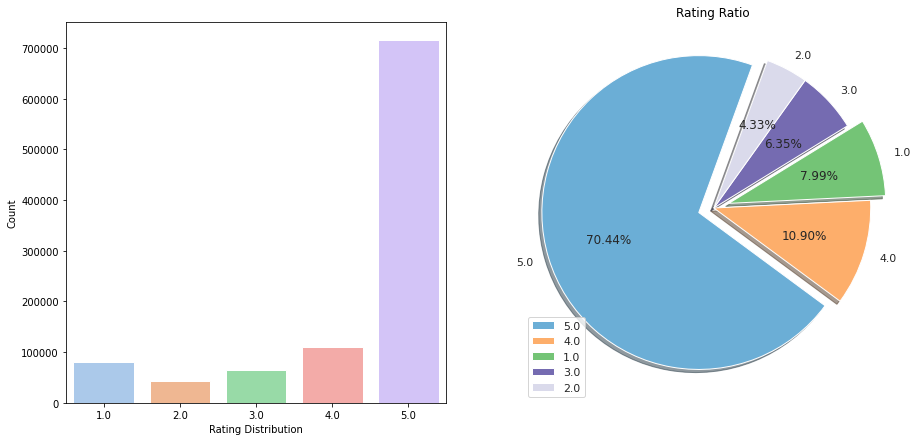

In [18]:
#Countplot of the ratings, maximum user-products have got rating as 5
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,7))
sns.set_theme(style="whitegrid", palette="pastel")
sns.countplot(rev1['overall'], ax=ax1)
ax1.set_xlabel('Rating Distribution', fontsize=10)
ax1.set_ylabel('Count', fontsize=10)
cmap = plt.get_cmap("tab20c")


explode = (0.1, 0, 0.1, 0, 0)
ax2.pie(rating_cnt["Ratings"], explode=explode, labels=rating_cnt.Labels, autopct='%1.2f%%',
        shadow=True, startangle=70,colors = cmap([1,6,9,12,15]))
ax2.axis('equal')
plt.title("Rating Ratio")
plt.legend(rating_cnt.Labels, loc=3)
plt.show()

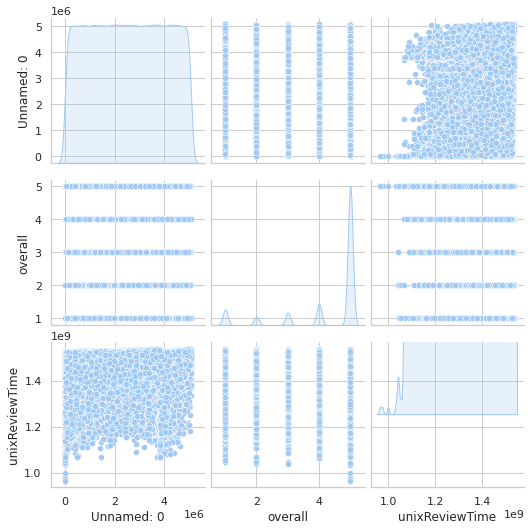

In [19]:
sns.pairplot(rev1, diag_kind= 'kde')

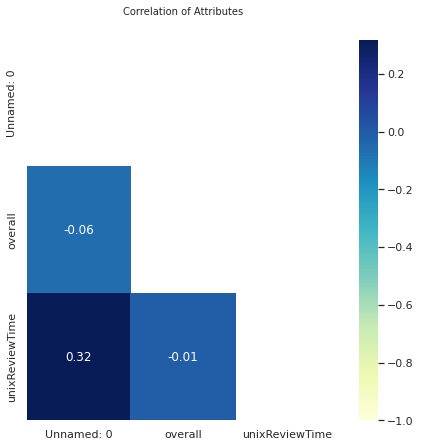

In [20]:
#correlations
mask = np.zeros_like(rev1.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(7,7))
plt.title('Correlation of Attributes', y=1.05, size=10)
sns.heatmap(rev1.corr(),vmin=-1, cmap='YlGnBu',annot=True,  mask=mask, fmt='.2f')

In [21]:
#Summary of the data
print("Data Summary....................................................................................")
print("\nTotal number of Ratings :",rev1.shape[0])
print("Total number of Users   :", len(np.unique(rev1.reviewerID)))
print("Total number of Products  :", len(np.unique(rev1.asin)))

Data Summary....................................................................................

Total number of Ratings : 1014832
Total number of Users   : 789157
Total number of Products  : 152360


In [23]:
#Check and find the max ratings given by user for a particular item
max_rat = rev1.groupby(['reviewerID','asin'])['overall'].max().sort_values(ascending=False)
max_rat

reviewerID      asin      
A3EBAPIFCY0EKF  B01DPO76QS    5.0
A2YE606NDOZZ8F  B0183RU6UU    5.0
A1O419KNAF8T6   B000PE4EZI    5.0
A1O41ROIGXKF5T  B00UUKN6YC    5.0
A2YEFZ0YUOWLKP  B0059AJ3MM    5.0
                             ... 
A1HWC6W3ONKU24  B01133LB1E    1.0
A1HWDMUKKM29AV  B00VO4LDDY    1.0
A3FCCJN9OL4U10  B00I3K37FO    1.0
A3FC9L88QGGAUF  B00451W2ZG    1.0
A3E6ZXKO41A15K  B005TH72FK    1.0
Name: overall, Length: 1007023, dtype: float64

In [24]:
#Check and find the min ratings given by user for a particular item
min_rat = rev1.groupby(['reviewerID','asin'])['overall'].min().sort_values(ascending=False)
min_rat

reviewerID      asin      
A20NFIHBSSF0Z1  B001SAWZOK    5.0
A30BABERWUBWJQ  B015JRJ6JY    5.0
A30BBH7V9B8I2W  B01F7Q8YIG    5.0
                B01EIHD192    5.0
                B00OE5BN08    5.0
                             ... 
A17MJFYJI5LNFD  B000YBKP50    1.0
A1CN8SVVTTVB5D  B00JVLPXLK    1.0
A2W6OOTWAZOFZJ  B00LBGM5N2    1.0
A1HHYNL53ABAOG  B00MW8H4B6    1.0
A2UJNN4EWZSO53  B00NAWUQAO    1.0
Name: overall, Length: 1007023, dtype: float64

In [25]:

no_rat_each_person = rev1.groupby(by='reviewerID')['overall'].count().sort_values(ascending=False)
no_rat_each_person.head(10)

reviewerID
A1LACH6MLQWZ      228
A1GQAKL9CGQLP1    161
A2GJX2KCUSR0EI    117
A2C9XE9I8RSKNX    102
AY12DBB0U420B      95
A2NYK9KWFMJV4Y     89
A2Q7DE6NA7VKAJ     86
A3OXHLG6DIBRW8     83
A281NPSIMI1C2R     83
A2MNB77YGJ3CN0     78
Name: overall, dtype: int64

In [25]:
no_rat_each_person.describe().astype(int)

count    789157
mean          1
std           1
min           1
25%           1
50%           1
75%           1
max         228
Name: overall, dtype: int64

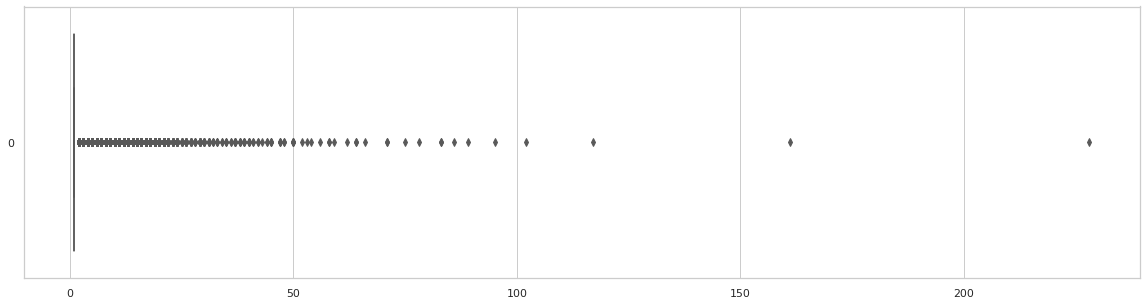

In [26]:
plt.figure(figsize=(20,5))
sns.boxplot(data=no_rat_each_person, orient='h', palette='Set2', dodge=False)

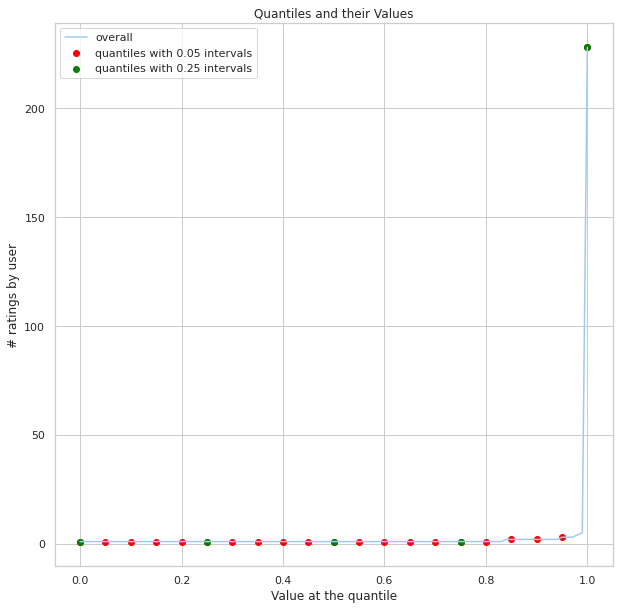

In [27]:
#We can see that all the ratings are clustered at the top end of the quantile

quantiles = no_rat_each_person.quantile(np.arange(0,1.01,0.01), interpolation='higher')
plt.figure(figsize=(10,10))
plt.title("Quantiles and their Values")
quantiles.plot()
plt.scatter(x=quantiles.index[::5], y=quantiles.values[::5], c='red', label="quantiles with 0.05 intervals")
plt.scatter(x=quantiles.index[::25], y=quantiles.values[::25], c='green', label = "quantiles with 0.25 intervals")
plt.ylabel('# ratings by user')
plt.xlabel('Value at the quantile')
plt.legend(loc='best')
plt.show()

**Taking a Denser dataset**

In [26]:
print('\n number of rated product more than 10 per user : {}\n'.format(sum( no_rat_each_person>=10)) )
new_df=rev1.groupby("reviewerID").filter(lambda x:x['overall'].count() >=10)


 number of rated product more than 10 per user : 1617



In [27]:
#total no. of rating for each person
new_df.groupby(by='reviewerID')['overall'].count().sort_values(ascending=False)
no_rat_each_person.head(10)

reviewerID
A1LACH6MLQWZ      228
A1GQAKL9CGQLP1    161
A2GJX2KCUSR0EI    117
A2C9XE9I8RSKNX    102
AY12DBB0U420B      95
A2NYK9KWFMJV4Y     89
A2Q7DE6NA7VKAJ     86
A3OXHLG6DIBRW8     83
A281NPSIMI1C2R     83
A2MNB77YGJ3CN0     78
Name: overall, dtype: int64

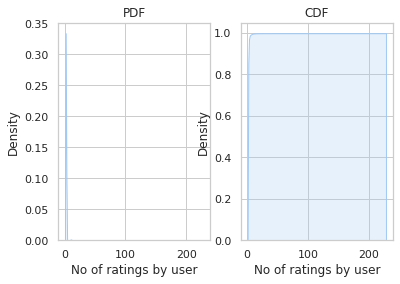

In [30]:
#PDF and CDF for the number of ratings per user
#PDF is left skewed as majority of the users have given very few ratings
ax1 = plt.subplot(121)
sns.kdeplot(no_rat_each_person, shade=True, ax=ax1)
plt.xlabel('No of ratings by user')
plt.title("PDF")

ax2 = plt.subplot(122)
sns.kdeplot(no_rat_each_person, shade=True, cumulative=True,ax=ax2)
plt.xlabel('No of ratings by user')
plt.title('CDF')

plt.show()

<function matplotlib.pyplot.show>

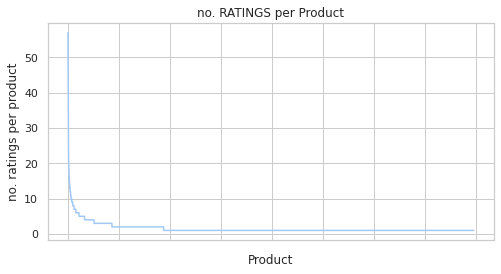

In [31]:
#plot of number of ratings per product
no_of_ratings_per_product = new_df.groupby(by='asin')['overall'].count().sort_values(ascending=False)

fig = plt.figure(figsize=plt.figaspect(.5))
ax = plt.gca()
plt.plot(no_of_ratings_per_product.values)
plt.title('no. RATINGS per Product')
plt.xlabel('Product')
plt.ylabel('no. ratings per product')
ax.set_xticklabels([])

plt.show

In [32]:
quantiles = no_of_ratings_per_product.quantile(np.arange(0,1.01,0.01), interpolation='higher')

In [33]:
#mean rating of items
rating = pd.DataFrame(ratings.groupby('asin')['overall'].mean())
rating.head(5)

,overall
asin,
4639725043,5.000000
4639725183,5.000000
4858582000,5.000000
5463213682,4.666667
6163058011,3.000000


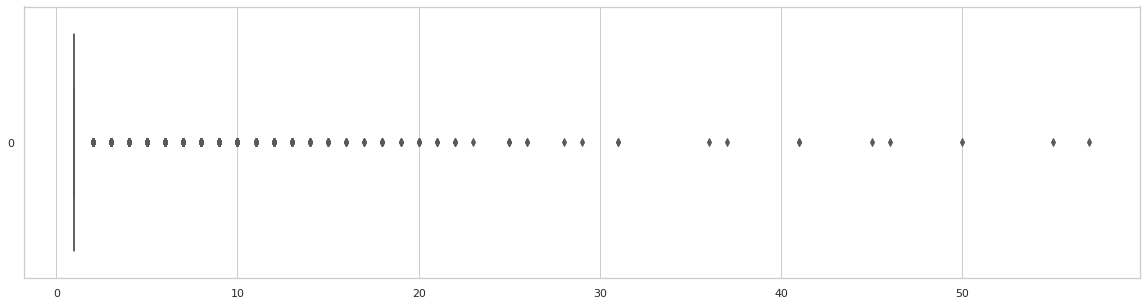

In [34]:
plt.figure(figsize=(20,5))
sns.boxplot(data=no_of_ratings_per_product, orient='h', palette='Set2', dodge=False)

In [38]:
copy_year=deepcopy(df1)

In [39]:
#Extract Year
def year_extract(reviewTime):
    year = reviewTime[-4:]
    return year

copy_year['Year'] = copy_year['reviewTime'].apply(year_extract)

In [40]:
l=copy_year['Year'].value_counts()
year_count=l.to_frame()

In [41]:
year_count.rename({'Year':'count'}, axis=1,inplace=True)
year_count.reset_index(level=0, inplace=True)
year_count.rename({'index':'year'}, axis=1,inplace=True)
year_count.head(5)

,year,count
0,2016,223486
1,2017,203632
2,2015,193838
3,2014,125258
4,2018,118414


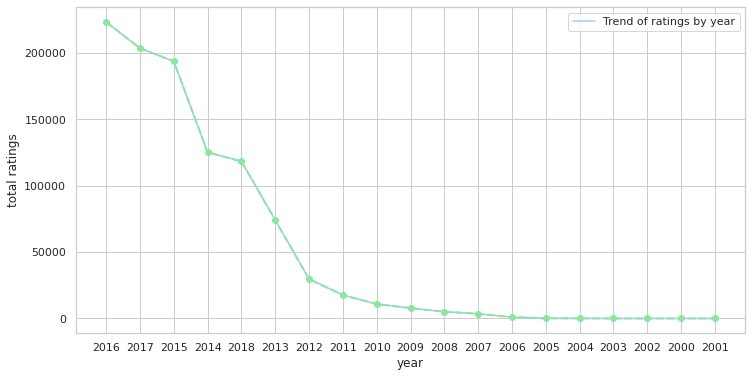

In [42]:
#year wise total number of sell
import matplotlib.pyplot as plt
  
x = year_count['year']
y = year_count['count']

  
# Plotting the Data
plt.figure(figsize=(12,6))
plt.plot(x, y, label='Trend of ratings by year')
  
plt.xlabel('year')
plt.ylabel('total ratings')
  
plt.plot(y, 'o:g', linestyle='--', linewidth='2')

  
plt.legend()

In [43]:
#Total no of rating for product
new_df.groupby('asin')['overall'].count().sort_values(ascending=False).head()

asin
B000U0OUP6    57
B00BUKL666    55
B000E1FZHS    50
B0001LO3FG    46
B000F4DKAI    45
Name: overall, dtype: int64

In [44]:
#mean rating for a product
ratings_mean_count = pd.DataFrame(new_df.groupby('asin')['overall'].mean())

In [45]:
ratings_mean_count.head(5)

,overall
asin,
9742356831,5.000000
B00005BPQ9,4.666667
B00006BN4U,4.000000
B00006IDJU,5.000000
B00006IDK9,3.500000


In [46]:
ratings_mean_count['rating_counts'] = pd.DataFrame(new_df.groupby('asin')['overall'].count())
ratings_mean_count.head(5)

,overall,rating_counts
asin,,
9742356831,5.000000,3
B00005BPQ9,4.666667,3
B00006BN4U,4.000000,2
B00006IDJU,5.000000,1
B00006IDK9,3.500000,2


In [47]:

#Total no of rating for product

new_df.groupby('asin')['overall'].count().sort_values(ascending=False).head()

asin
B000U0OUP6    57
B00BUKL666    55
B000E1FZHS    50
B0001LO3FG    46
B000F4DKAI    45
Name: overall, dtype: int64

In [48]:
ratings_mean_count['rating_counts'].max()

57

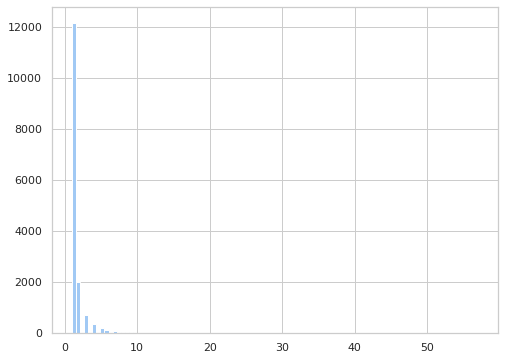

In [49]:
#Majority of the products have received 1 rating only and it is a right skewed distribution
plt.figure(figsize=(8,6))
ratings_mean_count['rating_counts'].hist(bins=100)

<Figure size 576x432 with 0 Axes>

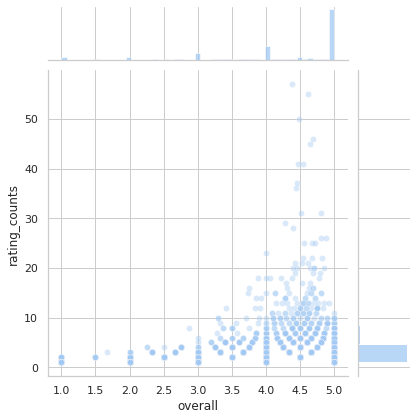

In [50]:
#From the joint plot below it seems that popular products (higher ratings) tend to be rated more frequently
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
sns.jointplot(x='overall', y='rating_counts', data=ratings_mean_count, alpha=0.4)

In [51]:
ratings_mean_count['rating_counts'] = pd.DataFrame(new_df.groupby('asin')['overall'].count())
ratings_mean_count.head()

,overall,rating_counts
asin,,
9742356831,5.000000,3
B00005BPQ9,4.666667,3
B00006BN4U,4.000000,2
B00006IDJU,5.000000,1
B00006IDK9,3.500000,2


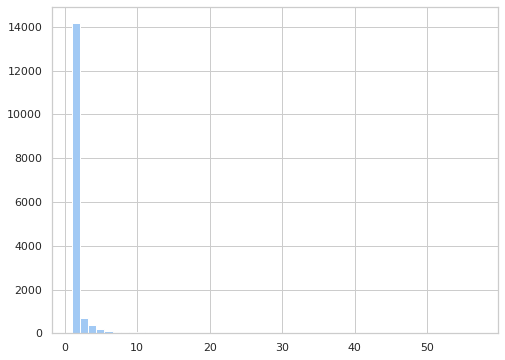

In [52]:
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
ratings_mean_count['rating_counts'].hist(bins=50)

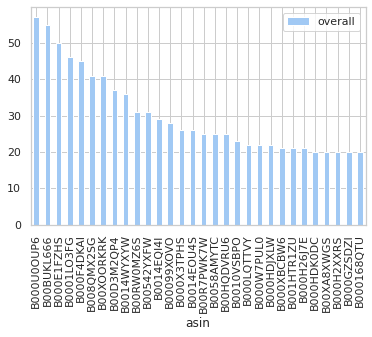

In [53]:
#Below is the bar graph showing product list of top 30 most popular products
popular_products = pd.DataFrame(new_df.groupby('asin')['overall'].count())
most_popular = popular_products.sort_values('overall', ascending=False)
most_popular.head(30).plot(kind = "bar")

## Data Preprocessing

CREATING SUBSET BY YEAR

In [28]:
def year(reviewTime):
  year = reviewTime[-4:]
  return year
new_df['Year'] = new_df['reviewTime'].apply(year)
new_df['Year'].value_counts()

2015    5379
2016    4952
2014    4084
2017    3623
2013    2420
2018    1337
2012    1233
2011     743
2010     500
2009     454
2008     292
2007     159
2006      79
2005      13
2003       1
2004       1
Name: Year, dtype: int64

In [29]:
sub_data=deepcopy(new_df)

In [30]:
sub_data.drop(sub_data[sub_data['Year']=='2004'].index, inplace=True)
sub_data.drop(sub_data[sub_data['Year']=='2005'].index, inplace=True)
sub_data.drop(sub_data[sub_data['Year']=='2006'].index, inplace=True)
sub_data.drop(sub_data[sub_data['Year']=='2007'].index, inplace=True)
sub_data.drop(sub_data[sub_data['Year']=='2008'].index, inplace=True)
sub_data.drop(sub_data[sub_data['Year']=='2009'].index, inplace=True)

In [31]:
sub_data

,Unnamed: 0,overall,reviewTime,reviewerID,asin,unixReviewTime,Year
88,2758330,4.0,"09 5, 2015",A15VNRVR8YW1VK,B00HJUC8CC,1441411200,2015
93,3527048,4.0,"04 7, 2016",A1B70ZEWQ6UH1A,B014V10S4Q,1459987200,2016
96,204307,5.0,"10 15, 2015",A1V1KX694CFTHO,B000E4ALEW,1444867200,2015
233,3689368,5.0,"07 17, 2016",A3OW12V8O7G5LD,B01CO69SA0,1468713600,2016
338,2232131,5.0,"09 26, 2014",A2SQJPUCZNHMZE,B00AZZX6XI,1411689600,2014
...,...,...,...,...,...,...,...
1014571,3085360,4.0,"03 12, 2016",A3G7SI5RCNWKZJ,B00N23JPZI,1457740800,2016
1014586,2305396,5.0,"11 4, 2015",A2HEK4JP1XQNH9,B00BU4DQKQ,1446595200,2015
1014589,2565555,5.0,"12 18, 2015",A1N8AT1SQ294K1,B00EKR4BVI,1450396800,2015
1014647,1572162,2.0,"12 29, 2014",AYOMAHLWRQHUG,B004NO7QX8,1419811200,2014


In [32]:
ratings = deepcopy(sub_data)
ratings.drop(['Year','reviewTime'],axis=1, inplace = True)
ratings.fillna(value = 0, inplace = True)
ratings.drop_duplicates
ratings

,Unnamed: 0,overall,reviewerID,asin,unixReviewTime
88,2758330,4.0,A15VNRVR8YW1VK,B00HJUC8CC,1441411200
93,3527048,4.0,A1B70ZEWQ6UH1A,B014V10S4Q,1459987200
96,204307,5.0,A1V1KX694CFTHO,B000E4ALEW,1444867200
233,3689368,5.0,A3OW12V8O7G5LD,B01CO69SA0,1468713600
338,2232131,5.0,A2SQJPUCZNHMZE,B00AZZX6XI,1411689600
...,...,...,...,...,...
1014571,3085360,4.0,A3G7SI5RCNWKZJ,B00N23JPZI,1457740800
1014586,2305396,5.0,A2HEK4JP1XQNH9,B00BU4DQKQ,1446595200
1014589,2565555,5.0,A1N8AT1SQ294K1,B00EKR4BVI,1450396800
1014647,1572162,2.0,AYOMAHLWRQHUG,B004NO7QX8,1419811200


In [33]:
from copy import deepcopy
meta_copy=deepcopy(df_metadata)

In [34]:
meta_copy=meta_copy[['asin','category']]

In [35]:
meta_list=meta_copy.values.tolist()
meta_list[:10]

[['0681727810',
  ['Grocery & Gourmet Food', 'Dairy, Cheese & Eggs', 'Cheese', 'Gouda']],
 ['0853347867',
  ['Grocery & Gourmet Food',
   'Cooking & Baking',
   'Sugar Substitutes',
   'Xylitol']],
 ['1888861118',
  ['Grocery & Gourmet Food',
   'Cooking & Baking',
   'Frosting, Icing & Decorations',
   'Cake & Cupcake Toppers',
   'Cake Toppers']],
 ['1888861517',
  ['Grocery & Gourmet Food',
   'Cooking & Baking',
   'Frosting, Icing & Decorations',
   'Cake & Cupcake Toppers',
   'Cake Toppers']],
 ['1888861614',
  ['Grocery & Gourmet Food',
   'Cooking & Baking',
   'Frosting, Icing & Decorations',
   'Cake & Cupcake Toppers',
   'Cake Toppers']],
 ['1888861533',
  ['Grocery & Gourmet Food',
   'Cooking & Baking',
   'Frosting, Icing & Decorations',
   'Cake & Cupcake Toppers',
   'Cake Toppers']],
 ['1888861339',
  ['Grocery & Gourmet Food',
   'Cooking & Baking',
   'Frosting, Icing & Decorations',
   'Cake & Cupcake Toppers',
   'Cake Toppers']],
 ['1888861355',
  ['Grocery & Go

In [36]:
type(meta_list[1][1])

list

In [37]:
meta_list[1][1]

['Grocery & Gourmet Food', 'Cooking & Baking', 'Sugar Substitutes', 'Xylitol']

In [38]:
category_list=[]
for i in range(len(meta_list)):
    s=[]
    s.append(meta_list[i][0]) 
    s.append(meta_list[i][1][1])
    category_list.append(s)

In [39]:
df_cat_asin=pd.DataFrame(category_list)

In [40]:
df_cat_asin

,0,1
0,0681727810,"Dairy, Cheese & Eggs"
1,0853347867,Cooking & Baking
2,1888861118,Cooking & Baking
3,1888861517,Cooking & Baking
4,1888861614,Cooking & Baking
...,...,...
287046,B01HJFBN9A,"Jams, Jellies & Sweet Spreads"
287047,B01HJFC704,Condiments & Salad Dressings
287048,B01HJF6FRA,Condiments & Salad Dressings
287049,B01HJHSVG6,"Herbs, Spices & Seasonings"


In [41]:
df_cat_asin.rename({0:'asin',1:'category_type'}, axis=1,inplace=True)

In [42]:
df_cat_asin.head(5)

,asin,category_type
0,0681727810,"Dairy, Cheese & Eggs"
1,0853347867,Cooking & Baking
2,1888861118,Cooking & Baking
3,1888861517,Cooking & Baking
4,1888861614,Cooking & Baking


In [43]:
df_inner = pd.merge(df1,df_cat_asin, on='asin', how='inner')

df_inner.head(3)

,Unnamed: 0,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,image,style,category_type
0,2029665,3.0,True,"03 25, 2014",A17GONA7VU3OVP,B007SM6NWC,Dennis P Harper,"I like the taste, texture, and idea of this fl...",Good but pricey,1395705600,NaN,NaN,NaN,Cooking & Baking
1,2029514,5.0,True,"05 6, 2016",A3JX7Z431AZ40S,B007SM6NWC,Danielle R.,love it,Five Stars,1462492800,NaN,NaN,NaN,Cooking & Baking
2,2029491,4.0,True,"09 12, 2016",AI9R0YEDPSWPL,B007SM6NWC,Adele,So far just made banana chocolate chip bread a...,Tasted good and texture was good too,1473638400,NaN,NaN,NaN,Cooking & Baking


In [44]:
df_inner['category_type'].value_counts()

Beverages                             308197
Cooking & Baking                      190114
Candy & Chocolate                     127721
Snack Foods                           106325
Herbs, Spices & Seasonings             67248
Breakfast Foods                        34324
Canned, Jarred & Packaged Foods        27222
Sauces, Gravies & Marinades            26156
Food & Beverage Gifts                  20687
Jams, Jellies & Sweet Spreads          17927
Produce                                17045
Soups, Stocks & Broths                 14815
Dairy, Cheese & Eggs                   11091
Condiments & Salad Dressings           11009
Dried Beans, Grains & Rice             10661
Fresh Flowers & Live Indoor Plants     10378
Breads & Bakery                         9057
Pasta & Noodles                         8520
Meat & Seafood                          6270
Olives, Pickles & Relishes              4296
Frozen                                  3390
Prepared Foods                          1149
Meat Subst

In [45]:
prod1 = deepcopy(df_inner)
prod2 = prod1[['asin', 'category_type']]

In [46]:
prod2

,asin,category_type
0,B007SM6NWC,Cooking & Baking
1,B007SM6NWC,Cooking & Baking
2,B007SM6NWC,Cooking & Baking
3,B007SM6NWC,Cooking & Baking
4,B007SM6NWC,Cooking & Baking
...,...,...
1035091,B00HZ0OOM8,Cooking & Baking
1035092,B002WDNFEQ,Snack Foods
1035093,B00BX6GICO,Beverages
1035094,B00R584U8S,Frozen


## Approach - 1
```
Applying ALS method on the data straight forward
```

Stratified Train Test

In [47]:
data = spark.createDataFrame(ratings[['reviewerID', 'asin', 'overall']])
indexer = [StringIndexer(inputCol = column, outputCol = column+"index") for column in ['asin','reviewerID']]
pipeline = Pipeline(stages=indexer)
data = pipeline.fit(data).transform(data)

In [48]:
transformed_train = data.sampleBy("overall", fractions={1: 0.7, 2: 0.7, 3: 0.7,4: 0.7,5: 0.7}, seed=10)
transformed_test = data.subtract(transformed_train)

In [49]:
transformed_train = transformed_train.withColumnRenamed('overall','label')

In [50]:
transformed_test = transformed_test.withColumnRenamed('overall','truelabel')

In [52]:
als = ALS(maxIter = 20, regParam = 0.05 ,userCol = 'reviewerIDindex', itemCol = 'asinindex', ratingCol = 'label', coldStartStrategy='drop', nonnegative=True)
model = als.fit(transformed_train)

In [53]:
prediction = model.transform(transformed_test)

In [54]:
prediction.show(n=5, truncate = False)

+--------------+----------+---------+---------+---------------+----------+
|reviewerID    |asin      |truelabel|asinindex|reviewerIDindex|prediction|
+--------------+----------+---------+---------+---------------+----------+
|ANTWFVZZKSBSF |B003XUJ564|2.0      |148.0    |502.0          |3.3268466 |
|A3HUK2D3SNXHMR|B003XUJ564|2.0      |148.0    |1386.0         |3.7745779 |
|A2582KMXLK2P06|B000NBWO1E|5.0      |463.0    |127.0          |3.8706758 |
|A397CWU6DM3O5G|B000NBWO1E|5.0      |463.0    |717.0          |4.111083  |
|A37CENQP0ZNKVE|B000NBWO1E|5.0      |463.0    |42.0           |4.91519   |
+--------------+----------+---------+---------+---------------+----------+
only showing top 5 rows



In [55]:
evaluator = RegressionEvaluator(labelCol='truelabel',predictionCol='prediction', metricName='rmse')
rmse = evaluator.evaluate(prediction)
print("Root Mean Square Error(RMSE):", rmse)

Root Mean Square Error(RMSE): 1.5873728393542315


## Approach - 2
```
Applying ALS Model on Over Sampled Data
```

Creating Over Sampled Data

In [56]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split 

ratings=deepcopy(sub_data)

#ratings,rat = train_test_split(ratings1, test_size=0.5, stratify=ratings['overall'])

In [57]:
sub_data

,Unnamed: 0,overall,reviewTime,reviewerID,asin,unixReviewTime,Year
88,2758330,4.0,"09 5, 2015",A15VNRVR8YW1VK,B00HJUC8CC,1441411200,2015
93,3527048,4.0,"04 7, 2016",A1B70ZEWQ6UH1A,B014V10S4Q,1459987200,2016
96,204307,5.0,"10 15, 2015",A1V1KX694CFTHO,B000E4ALEW,1444867200,2015
233,3689368,5.0,"07 17, 2016",A3OW12V8O7G5LD,B01CO69SA0,1468713600,2016
338,2232131,5.0,"09 26, 2014",A2SQJPUCZNHMZE,B00AZZX6XI,1411689600,2014
...,...,...,...,...,...,...,...
1014571,3085360,4.0,"03 12, 2016",A3G7SI5RCNWKZJ,B00N23JPZI,1457740800,2016
1014586,2305396,5.0,"11 4, 2015",A2HEK4JP1XQNH9,B00BU4DQKQ,1446595200,2015
1014589,2565555,5.0,"12 18, 2015",A1N8AT1SQ294K1,B00EKR4BVI,1450396800,2015
1014647,1572162,2.0,"12 29, 2014",AYOMAHLWRQHUG,B004NO7QX8,1419811200,2014


In [58]:
ratings = pd.DataFrame(ratings)
overall_group= ratings.groupby('overall')
rating_5= overall_group.get_group(5.0)
count_five = len(rating_5)
def oversampling(subset):
    count = len(subset)
    n=int(count_five/count)
    return (n)

In [59]:
n1 = overall_group.get_group(1.0)
one_rating = overall_group.get_group(1.0)
rat_1= pd.concat([one_rating]*oversampling(one_rating),ignore_index=True)

n2 = overall_group.get_group(1.0)
two_rating = overall_group.get_group(2.0)
rat_2= pd.concat([two_rating]*oversampling(two_rating),ignore_index=True)

n3 = overall_group.get_group(1.0)
three_rating = overall_group.get_group(3.0)
rat_3= pd.concat([three_rating]*oversampling(three_rating),ignore_index=True)

n4 = overall_group.get_group(1.0)
four_rating = overall_group.get_group(4.0)
rat_4= pd.concat([four_rating]*oversampling(four_rating),ignore_index=True)

rat_5=rating_5

In [60]:
oversampled_data= pd.concat([rat_5,rat_4,rat_3,rat_2,rat_1])
oversampled_data= oversampled_data.sample(frac=1,random_state=42)
oversampled_data

,Unnamed: 0,overall,reviewTime,reviewerID,asin,unixReviewTime,Year
12227,3478719,1.0,"03 17, 2017",A1POGQGNJ31Y7A,B0123QWXO4,1489708800,2017
12770,1401437,3.0,"01 10, 2018",A34SPFZIHHN907,B003UY9FYA,1515542400,2018
12967,4287702,1.0,"11 18, 2013",A24TCT2CY6KY68,B006V2IT4K,1384732800,2013
463478,2450296,5.0,"02 1, 2016",AN0N05A9LIJEQ,B00DBWU2WU,1454284800,2016
5853,752382,4.0,"06 4, 2015",A15WDJOU6B9FLQ,B000WV0RW8,1433376000,2015
...,...,...,...,...,...,...,...
8250,2180708,3.0,"09 2, 2014",AG45E4H4MVWOB,B00AACN2NU,1409616000,2014
398586,117858,5.0,"12 28, 2015",A2SQX1JEILPH9I,B00099XK6I,1451260800,2015
9998,2060034,2.0,"05 28, 2015",A1GQAKL9CGQLP1,B008CFOACO,1432771200,2015
54042,736546,5.0,"04 9, 2015",A26K3T6L5NYO7L,B000W7PUL0,1428537600,2015


### Train Test Split

In [62]:
ratings=deepcopy(oversampled_data)

In [63]:
data = spark.createDataFrame(ratings[['reviewerID', 'asin', 'overall']])
indexer = [StringIndexer(inputCol = column, outputCol = column+"index") for column in ['asin','reviewerID']]
pipeline = Pipeline(stages=indexer)
data = pipeline.fit(data).transform(data)

In [64]:
transformed_train = data.sampleBy("overall", fractions={1: 0.7, 2: 0.7, 3: 0.7,4: 0.7,5: 0.7}, seed=10)
transformed_test = data.subtract(transformed_train)

In [65]:
transformed_train = transformed_train.withColumnRenamed('overall','label')
transformed_test = transformed_test.withColumnRenamed('overall','truelabel')

In [ ]:
als = ALS(maxIter = 20, regParam = 0.05 ,userCol = 'reviewerIDindex', itemCol = 'asinindex', ratingCol = 'label', coldStartStrategy='drop', nonnegative=True)
model = als.fit(transformed_train)

In [ ]:
prediction = model.transform(transformed_test)

In [109]:
evaluator = RegressionEvaluator(labelCol='truelabel',predictionCol='prediction', metricName='rmse')
rmse = evaluator.evaluate(prediction)
print("Root Mean Square Error(RMSE):", rmse)

Root Mean Square Error(RMSE): 1.908255712609219


avoid oversampling

In [67]:
ratings=deepcopy(sub_data)
ratings.drop(['Year','reviewTime'],axis=1, inplace = True)
ratings.fillna(value = 0, inplace = True)
ratings.drop_duplicates
ratings

,Unnamed: 0,overall,reviewerID,asin,unixReviewTime
88,2758330,4.0,A15VNRVR8YW1VK,B00HJUC8CC,1441411200
93,3527048,4.0,A1B70ZEWQ6UH1A,B014V10S4Q,1459987200
96,204307,5.0,A1V1KX694CFTHO,B000E4ALEW,1444867200
233,3689368,5.0,A3OW12V8O7G5LD,B01CO69SA0,1468713600
338,2232131,5.0,A2SQJPUCZNHMZE,B00AZZX6XI,1411689600
...,...,...,...,...,...
1014571,3085360,4.0,A3G7SI5RCNWKZJ,B00N23JPZI,1457740800
1014586,2305396,5.0,A2HEK4JP1XQNH9,B00BU4DQKQ,1446595200
1014589,2565555,5.0,A1N8AT1SQ294K1,B00EKR4BVI,1450396800
1014647,1572162,2.0,AYOMAHLWRQHUG,B004NO7QX8,1419811200


## Approach - 3
```
ALS model on Automated Optimized Data
```

### Creating Automated **Optimized** Data

In [68]:
# Tuning the parameters to find the minimum RMSE value by optimizing iterations and regular parameters
Score=[]
maxIter=[5,10,15]
regParam=[0.10,0.20,0.30,0.40]
rank=[5,10]
for j in maxIter:
    for i in regParam:
        for k in rank:
        
            als = ALS(rank=k, maxIter = j, regParam = i, userCol = 'reviewerIDindex', itemCol = 'asinindex', ratingCol = 'label', coldStartStrategy='drop', nonnegative=True)
            model = als.fit(transformed_train)
            prediction = model.transform(transformed_test)
            #prediction.show(n=5, truncate = False)

            evaluator = RegressionEvaluator(labelCol='truelabel',predictionCol='prediction', metricName='rmse')
            rmse = evaluator.evaluate(prediction)
            print("Root Mean Square Error(RMSE):", rmse)
            l=[]
            l.append(j)
            l.append(i)
            l.append(rmse)
            l.append(k)
            Score.append(l)

Root Mean Square Error(RMSE): 2.004764528925947
Root Mean Square Error(RMSE): 2.0268036899107393
Root Mean Square Error(RMSE): 1.8594468548891996
Root Mean Square Error(RMSE): 1.9130573103543491
Root Mean Square Error(RMSE): 1.8614357423280103
Root Mean Square Error(RMSE): 1.9008475590497014
Root Mean Square Error(RMSE): 1.901240878229996
Root Mean Square Error(RMSE): 1.9341790089650124
Root Mean Square Error(RMSE): 1.8661657334242754
Root Mean Square Error(RMSE): 1.8586453802692442
Root Mean Square Error(RMSE): 1.7660518856558705
Root Mean Square Error(RMSE): 1.7966960758319381
Root Mean Square Error(RMSE): 1.7734000749236873
Root Mean Square Error(RMSE): 1.7926734961598412
Root Mean Square Error(RMSE): 1.8035891242119635
Root Mean Square Error(RMSE): 1.81610968484654
Root Mean Square Error(RMSE): 1.8120079895152805
Root Mean Square Error(RMSE): 1.793707890570515
Root Mean Square Error(RMSE): 1.740046311996973
Root Mean Square Error(RMSE): 1.7646730691437007
Root Mean Square Error(RMS

In [69]:
score=[]
for i in range(len(Score)):
    score.append(Score[i][2])

min_Score=min(score)
for i in range(len(Score)):
    if Score[i][2]==min_Score:
        iter=Score[i][0]
        para=Score[i][1]
        rank=Score[i][3]
r=rank

User based recommendation

In [70]:
def reco_user(id):
    temp_df = prediction.filter(prediction["reviewerID"] == id)
    temp_df = temp_df.sort("prediction", ascending=False)
    temp_df.show(n= 5, truncate = False)

In [84]:
reco_user("A3HUK2D3SNXHMR")

+--------------+----------+---------+---------+---------------+----------+
|reviewerID    |asin      |truelabel|asinindex|reviewerIDindex|prediction|
+--------------+----------+---------+---------+---------------+----------+
|A3HUK2D3SNXHMR|B000I6JPQQ|5.0      |5085.0   |765.0          |3.374506  |
|A3HUK2D3SNXHMR|B003DNL9PQ|5.0      |206.0    |765.0          |2.798688  |
+--------------+----------+---------+---------+---------------+----------+



Prediction

In [72]:
from pyspark.sql import SparkSession
#Create PySpark SparkSession
spark = SparkSession.builder.getOrCreate()
sparkDF=spark.createDataFrame(prod.astype(str))

In [73]:
jdf = prediction.join(sparkDF,prediction["asin"] ==  sparkDF["asin"],"inner")

In [74]:
jdf.show(n=5,truncate=False)

+--------------+----------+---------+---------+---------------+----------+----------+----------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------+
|reviewerID    |asin      |truelabel|asinindex|reviewerIDindex|prediction|asin      |title                                                                                   |category                                                                                        |
+--------------+----------+---------+---------+---------------+----------+----------+----------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------+
|A2UEZIWTVVY2HP|B000DZE0XK|5.0      |3527.0   |731.0          |4.2733727 |B000DZE0XK|Ghirardelli Chocolate Sweet Ground Chocolate &amp; Cocoa Beverage Mix, 48-Ounce Canister|['Grocery 

Recommendation  - category wise

In [75]:
from pyspark.sql import SparkSession
#Create PySpark SparkSession
spark = SparkSession.builder.getOrCreate()
sparkDF=spark.createDataFrame(prod2.astype(str))

In [76]:
jdf2 = prediction.join(sparkDF,prediction["asin"] ==  sparkDF["asin"],"inner")

In [77]:
ratings2 = deepcopy(df_inner)
ratings2.drop(['Unnamed: 0', 'verified', 'reviewTime', 
       'reviewerName', 'reviewText', 'summary', 'unixReviewTime', 'vote',
       'image', 'style'],axis=1, inplace = True)
ratings2.fillna(value = 0, inplace = True)
ratings2.drop_duplicates
ratings2

,overall,reviewerID,asin,category_type
0,3.0,A17GONA7VU3OVP,B007SM6NWC,Cooking & Baking
1,5.0,A3JX7Z431AZ40S,B007SM6NWC,Cooking & Baking
2,4.0,AI9R0YEDPSWPL,B007SM6NWC,Cooking & Baking
3,3.0,A1ELP3Q80YMORU,B007SM6NWC,Cooking & Baking
4,3.0,A2H396PEC4IKSG,B007SM6NWC,Cooking & Baking
...,...,...,...,...
1035091,5.0,A38UW285ITWHDS,B00HZ0OOM8,Cooking & Baking
1035092,4.0,AMVJELF5LH5K6,B002WDNFEQ,Snack Foods
1035093,5.0,A1RWYA52UUOCC0,B00BX6GICO,Beverages
1035094,3.0,A4HM7O5F684WC,B00R584U8S,Frozen


In [78]:
l=df_inner['category_type'].unique()
#l

In [79]:
ratings2.loc[ratings2['category_type']=='Cooking & Baking']

,overall,reviewerID,asin,category_type
0,3.0,A17GONA7VU3OVP,B007SM6NWC,Cooking & Baking
1,5.0,A3JX7Z431AZ40S,B007SM6NWC,Cooking & Baking
2,4.0,AI9R0YEDPSWPL,B007SM6NWC,Cooking & Baking
3,3.0,A1ELP3Q80YMORU,B007SM6NWC,Cooking & Baking
4,3.0,A2H396PEC4IKSG,B007SM6NWC,Cooking & Baking
...,...,...,...,...
1035061,3.0,A3DXU35JMQENO8,B007JVI60Y,Cooking & Baking
1035069,4.0,A36A27I11T5U49,B00DPUGI1W,Cooking & Baking
1035077,4.0,A1KH0U4O61YCDZ,B00F348ROY,Cooking & Baking
1035085,5.0,A1BKOF3W7KAI4V,B00CNW61LA,Cooking & Baking


### Final Recommendation systems

In [123]:
def preprocessed(data,r,iter,para):
    #preprocessed = ratings2.values.tolist()
    ##temp_data=data.loc[data['category_type']==cat]
    ##dff=pd.DataFrame(temp_data)
    ##temp_data_f=dff.drop(['category_type'],axis=1)
    
    data = spark.createDataFrame(data[['reviewerID', 'asin', 'overall']])
    indexer = [StringIndexer(inputCol = column, outputCol = column+"index") for column in ['asin','reviewerID']]
    pipeline = Pipeline(stages=indexer)
    data = pipeline.fit(data).transform(data)

    transformed_train = data.sampleBy("overall", fractions={1: 0.7, 2: 0.7, 3: 0.7,4: 0.7,5: 0.7}, seed=10)
    transformed_test = data.subtract(transformed_train)

    transformed_train = transformed_train.withColumnRenamed('overall','label')
    transformed_test = transformed_test.withColumnRenamed('overall','truelabel')

    als = ALS(rank=r, maxIter = iter, regParam = para, userCol = 'reviewerIDindex', itemCol = 'asinindex', ratingCol = 'label', coldStartStrategy='drop', nonnegative=True)
    model = als.fit(transformed_train)
    prediction = model.transform(transformed_test)
    jdf2 = prediction.join(sparkDF,prediction["asin"] ==  sparkDF["asin"],"inner")
    jdf2=jdf2.dropDuplicates(['reviewerID','asin','truelabel','asinindex','reviewerIDindex','prediction','asin','category_type'])
    #jdf2.show(n=5,truncate=False)
    return(jdf2)

In [124]:
def reco_user_category(user_id,cat,data,title,r,iter,para):
    temp_data=data.loc[data['category_type']==cat]
    dff=pd.DataFrame(temp_data)
    temp_data_f=dff.drop(['category_type'],axis=1)

    prediction=preprocessed(temp_data_f,r,iter,para)
    temp_df = prediction.filter(prediction["reviewerID"] == user_id)
    temp_df = temp_df.sort("prediction", ascending=False)
    pandas_df = temp_df.select("*").toPandas()
    #print(pandas_df)
    if len(pandas_df)<5:
        #popularity based
        ratings = pd.DataFrame(temp_data_f.groupby('asin')['overall'].median().sort_values(ascending=False).head())
        #print(ratings)
        ratings=pd.DataFrame(ratings)
        ratings.reset_index(inplace=True)
        #print(ratings)
        #print(ratings.columns)
        #print(type(ratings))
        
        recommendation=ratings[:5]
       # print(recommendation)
       # ratings.rename(columns={"overall": "Rating_Median"}, inplace=True)  
        l1=pandas_df.loc[:,'asin']
        #print(l1)
        l2=recommendation.loc[:,'asin']
        #print(l2)
        reco=l1.values.tolist()
        for i in l2.values.tolist():
            if i not in l1.values.tolist():
                reco.append(i)
            if len(reco)==5:
                break

    else:
       reco=pandas_df['asin'][:5]
    df = pd.DataFrame(reco)
    df.rename(columns={0: "asin"},inplace=True)
    recommend = pd.merge(df,title, on='asin', how='inner').drop_duplicates( keep='last')

    return(recommend)

In [82]:
reco_user_category('A38UW285ITWHD','Cooking & Baking',ratings2,prod_title,r,iter,para)

,asin,title
0,B01HJ2UYH0,Boho Party Cupcake Decorating Kit 72-Pieces In...
1,B007X9SHOW,"Baker's Cherry Pie Filling, 21-Ounce"
2,B007WK38W8,NFL San Francisco 49ers Cupcake Helmet Rings 1...
3,B007WMZ7RA,"MAUI BRAND Maui Gold Cane Sugar, 16 Ounce"
4,B007WRLQCU,Mazola Corn Oil - 16 oz


In [114]:
reco_user_category('A38UW285ITWHD','Cooking & Baking',ratings2,prod_title,r,iter,para)

,asin,title
0,B01HJ2UYH0,Boho Party Cupcake Decorating Kit 72-Pieces In...
1,B007X9SHOW,"Baker's Cherry Pie Filling, 21-Ounce"
2,B007WK38W8,NFL San Francisco 49ers Cupcake Helmet Rings 1...
3,B007WMZ7RA,"MAUI BRAND Maui Gold Cane Sugar, 16 Ounce"
4,B007WRLQCU,Mazola Corn Oil - 16 oz


### Recomendation for a user from all **Category**

In [83]:
list_category=df_inner['category_type'].unique()
for i in list_category[:4]:
    print(i)
    print(reco_user_category('A3HUK2D3SNXHMR',i,ratings2,prod_title,r,iter,para))

Cooking & Baking
         asin                                              title
0  B01HJ2UYH0  Boho Party Cupcake Decorating Kit 72-Pieces In...
1  B007X9SHOW               Baker's Cherry Pie Filling, 21-Ounce
2  B007WK38W8  NFL San Francisco 49ers Cupcake Helmet Rings 1...
3  B007WMZ7RA          MAUI BRAND Maui Gold Cane Sugar, 16 Ounce
4  B007WRLQCU                            Mazola Corn Oil - 16 oz
Herbs, Spices & Seasonings
         asin                                              title
0  B00ATJUONA  Sage, Ground-1Lb-Ground Sage Powder-Sausage Spice
1  B00642KB3E                            Goats Rue Powder - 1 lb
2  B00645QC2K  McCormick Garlic Powder Coarse Grind with Pars...
3  B00642PHGA                        Uva Ursi Leaf Powder - 1 lb
4  B00642OU1S                       Spearmint Leaf Powder - 1 lb
Beverages
         asin                                              title
0  B01HJCUNOO  Amara Unique Venezuelan Flavors. Hot Chocolate...
1  B007PY1BLQ  Rishi Tea Organic Ear

##Cross category

In [115]:
df_item_info = pd.merge(prod_title,df_cat_asin, on='asin', how='inner')

df_item_info.head(3)

,asin,title,category_type
0,0681727810,Beemster Gouda - Aged 18/24 Months - App. 1.5 Lbs,"Dairy, Cheese & Eggs"
1,0853347867,Trim Healthy Mama Xylitol,Cooking & Baking
2,1888861118,Letter C - Swarovski Crystal Monogram Wedding ...,Cooking & Baking


In [125]:
def popular(data):
    l=data['category_type'].unique()
    list_rec=[]
    for cat in l:
        temp_data=data.loc[data['category_type']==cat]
        dff=pd.DataFrame(temp_data)
        temp_data_f=dff.drop(['category_type'],axis=1)
        ratings = pd.DataFrame(temp_data_f.groupby('asin')['overall'].median().sort_values(ascending=False).head())
        ratings=pd.DataFrame(ratings)
        ratings.reset_index(inplace=True)
        
        recommendation=ratings[:5]
        l1=recommendation.loc[:,'asin']
        reco=l1.values.tolist()
        for i in reco:
            list_rec.append(i)
    return(list_rec)

In [126]:
def reco_user_cross_category(user_id,data,item,r,iter,para):
    

    user_list=ratings['reviewerID']
    user=[]
    for i in user_list:
        user.append(i)

    if user_id in user:
    
        user_subset=data.groupby('reviewerID')
        user_data=user_subset.get_group(user_id)
        user_category=user_data['category_type']
        cat_list=[]
        for i in user_category:
            if i not in cat_list:
                 cat_list.append(i)
        print('recommended categories for previous user',cat_list)
        for i in cat_list:
            print(i)
            print(reco_user_category(user_id,i,ratings2,prod_title,r,iter,para))

    else:
    
        top_rec=popular(data)
        print('recommendation for new user',top_rec)

In [88]:
type(prod_title)

pandas.core.frame.DataFrame

In [118]:
prod_title_list=prod_title.values.tolist()
prod_df=pd.DataFrame(prod_title_list)
print(type(prod_df),prod_df)

<class 'pandas.core.frame.DataFrame'>                  0                                                  1
0       0681727810  Beemster Gouda - Aged 18/24 Months - App. 1.5 Lbs
1       0853347867                          Trim Healthy Mama Xylitol
2       1888861118  Letter C - Swarovski Crystal Monogram Wedding ...
3       1888861517  Letter H - Swarovski Crystal Monogram Wedding ...
4       1888861614  Letter S - Swarovski Crystal Monogram Wedding ...
...            ...                                                ...
287046  B01HJFBN9A  Caffarel Fruit Jellies, Organic Assorted, 200 ...
287047  B01HJFC704      HAMPTON CREEK Spo Just Truffle Mayo, 12 Ounce
287048  B01HJF6FRA  HAMPTON CREEK Just Ranch Dressing, 12 Fluid Ounce
287049  B01HJHSVG6  Gourmet Pure Vanilla Bean Pastes - Organically...
287050  B01HJFRDDA  McClure's Pickles Bloody Mary Mix-Spicy-32 oz ...

[287051 rows x 2 columns]


In [119]:
prod_title

,asin,title
0,0681727810,Beemster Gouda - Aged 18/24 Months - App. 1.5 Lbs
1,0853347867,Trim Healthy Mama Xylitol
2,1888861118,Letter C - Swarovski Crystal Monogram Wedding ...
3,1888861517,Letter H - Swarovski Crystal Monogram Wedding ...
4,1888861614,Letter S - Swarovski Crystal Monogram Wedding ...
...,...,...
287046,B01HJFBN9A,"Caffarel Fruit Jellies, Organic Assorted, 200 ..."
287047,B01HJFC704,"HAMPTON CREEK Spo Just Truffle Mayo, 12 Ounce"
287048,B01HJF6FRA,"HAMPTON CREEK Just Ranch Dressing, 12 Fluid Ounce"
287049,B01HJHSVG6,Gourmet Pure Vanilla Bean Pastes - Organically...


In [109]:
ratings2

,overall,reviewerID,asin,category_type
0,3.0,A17GONA7VU3OVP,B007SM6NWC,Cooking & Baking
1,5.0,A3JX7Z431AZ40S,B007SM6NWC,Cooking & Baking
2,4.0,AI9R0YEDPSWPL,B007SM6NWC,Cooking & Baking
3,3.0,A1ELP3Q80YMORU,B007SM6NWC,Cooking & Baking
4,3.0,A2H396PEC4IKSG,B007SM6NWC,Cooking & Baking
...,...,...,...,...
1035091,5.0,A38UW285ITWHDS,B00HZ0OOM8,Cooking & Baking
1035092,4.0,AMVJELF5LH5K6,B002WDNFEQ,Snack Foods
1035093,5.0,A1RWYA52UUOCC0,B00BX6GICO,Beverages
1035094,3.0,A4HM7O5F684WC,B00R584U8S,Frozen


In [127]:
l=reco_user_cross_category('A3HUK2D3SNXHMR',ratings2,prod_title,r,iter,para)

recommended categories for previous user ['Canned, Jarred & Packaged Foods', 'Beverages', 'Cooking & Baking']
Canned, Jarred & Packaged Foods
         asin  ...                                              title
0  B00D7VGJKY  ...  Sea Best 41/50 Cooked Peeled and Deveined Shri...

[1 rows x 11 columns]
Beverages
         asin  ...                                              title
0  B002HQLY7S  ...  Gloria Jean's Coffees, Butter Toffee, K-Cup Po...

[1 rows x 11 columns]
Cooking & Baking
         asin  ...                                              title
0  B000I6JPQQ  ...  Hefty D28100 Soak Proof Tableware, Foam Plates...

[1 rows x 11 columns]


In [121]:
l=reco_user_cross_category('monalisa',ratings2,prod_title,r,iter,para)

recommendation for new user ['B01HJ2UYH0', 'B007X9SHOW', 'B007WK38W8', 'B007WMZ7RA', 'B007WRLQCU', 'B00ATJUONA', 'B00642KB3E', 'B00645QC2K', 'B00642PHGA', 'B00642OU1S', 'B01HJCUNOO', 'B007PY1BLQ', 'B007PM9YM6', 'B007PM9YNA', 'B007POP0DQ', 'B00CP3LMEI', 'B00A0ZL5OU', 'B00A3T4NIS', 'B00A3B1WKI', 'B00A32Q770', 'B01HIT10UY', 'B005HNO6FA', 'B005IPRJ5Q', 'B005IGIVX4', 'B005IGBQ0Y', 'B01HJ4FWGG', 'B007FXBSUG', 'B007G4Y8LU', 'B007FYUPCC', 'B007FXGGJE', 'B01HJ5Y05Y', 'B00687WS5O', 'B0067EO5S6', 'B0067EO5Q8', 'B0067EO3QA', 'B01HHZQ3IS', 'B00886EXQ0', 'B007ZELYPE', 'B007ZH9UJ8', 'B00822JS6U', 'B007DMFHU6', 'B001EO7DUQ', 'B001EPPZ1O', 'B001EPPKZK', 'B00ABJXKDO', 'B00B03D7NI', 'B005FIQCPE', 'B005H922DC', 'B005GWUPC0', 'B005GVCWWW', 'B01HC4IW4C', 'B0052OP310', 'B004Y0OIGO', 'B004YHDQYW', 'B004YV7ZKO', 'B01HFLGSFC', 'B00KAWT3NS', 'B007IW3EK6', 'B00K0TXP12', 'B00K0TIJ4U', 'B01HIEC0A8', 'B005GLDWXK', 'B005NIFZD6', 'B005MNO8CQ', 'B005MKA620', 'B01HH9IN64', 'B0018S09TK', 'B0078DU28C', 'B0078DU8CM', 'B007